In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 检查 CUDA 是否可用
print(f"CUDA available: {torch.cuda.is_available()}")

# 如果 CUDA 可用，打印当前设备名称
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")

# 获取 CUDA 版本
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# 获取 cuDNN 版本
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self,x):
        x=self.net(x)
        return x

CUDA available: True
Current device: NVIDIA GeForce GTX 1650
CUDA Version: 11.8
cuDNN Version: 90100
cuda


In [3]:
class PINN_Vibratec:
    def __init__(self, model, a, b, c):
        self.model = model
        self.a = a
        self.b = b
        self.c = c
        self.Losses = []
        self.file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\PINNs_ElasticMechanics\\PINNs_Vibrate_1D.pkl'
        
    def u_function(self, x):
        out = self.model(x)
        u = out[:,0:1]
        return u

    def u_grad(self, x):
        u = self.u_function(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        return u, u_x, u_xx
    
    def pde_Loss(self, x):
        u, u_x, u_xx = self.u_grad(x)
        f_L = self.f_function(x)
        temp = self.a * u_xx + self.b * u_x + self.c * u - f_L
        loss = torch.mean(torch.square(temp))
        return loss

    def data_Loss(self, x):
        u, u_x, u_xx = self.u_grad(x)
        loss = torch.mean(torch.square(u)) + torch.mean(torch.square(u_x - 2))
        return loss
        
    def f_function(self, x):
        f = 2*self.b*torch.cos(2*x) + (self.c-4*self.a)*torch.sin(2*x)
        return f

    def u_Exact(self, x):
        u = torch.sin(2*x)
        return u.cpu().detach().numpy()

    def train(self, x_pde, x_data, epochs, learning_rate):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=400, gamma=0.5)
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.pde_Loss(x_pde) + self.data_Loss(x_data)
            loss.backward()
            self.Losses.append(loss.item())
            self.optimizer.step()
            self.scheduler.step()
            if epoch % 100 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item():.8f}]")
                torch.save(self.model.state_dict(), self.file_name)
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
        torch.save(self.model.state_dict(), self.file_name)
        return loss

    def plot_loss(self):
        plt.title('log(loss)')
        plt.plot(np.log(self.Losses), label = 'Loss')
        plt.legend()
        plt.show()
        
    def predict(self, x):
        u = self.u_function(x)
        u = u.cpu().detach().numpy()
        return u
        
    def plot_result(self, x):
        u_np = self.predict(x)
        u_ex = self.u_Exact(x)
        x_np = x.cpu().detach().numpy()
        plt.title('Predict & Exact')
        plt.plot(x_np, u_np, label = 'Predict')
        plt.plot(x_np, u_ex, label = 'Exact', linestyle=':', marker='.')
        plt.legend()
        plt.show()

[Epoch 1/2000] [loss: 5.07134247]
[Epoch 101/2000] [loss: 1.07761753]
[Epoch 201/2000] [loss: 1.04524136]
[Epoch 301/2000] [loss: 1.03489363]
[Epoch 401/2000] [loss: 0.96970785]
[Epoch 501/2000] [loss: 0.93821526]
[Epoch 601/2000] [loss: 0.89064962]
[Epoch 701/2000] [loss: 0.84462291]
[Epoch 801/2000] [loss: 0.83525389]
[Epoch 901/2000] [loss: 0.62569660]
[Epoch 1001/2000] [loss: 0.29101828]
[Epoch 1101/2000] [loss: 0.03721330]
[Epoch 1201/2000] [loss: 0.00784955]
[Epoch 1301/2000] [loss: 0.00609771]
[Epoch 1401/2000] [loss: 0.00519863]
[Epoch 1501/2000] [loss: 0.00461031]
[Epoch 1601/2000] [loss: 0.00419513]
[Epoch 1701/2000] [loss: 0.00402844]
[Epoch 1801/2000] [loss: 0.00387745]
[Epoch 1901/2000] [loss: 0.00373874]
[Epoch 2000/2000] [loss: 0.0036108093336224556]


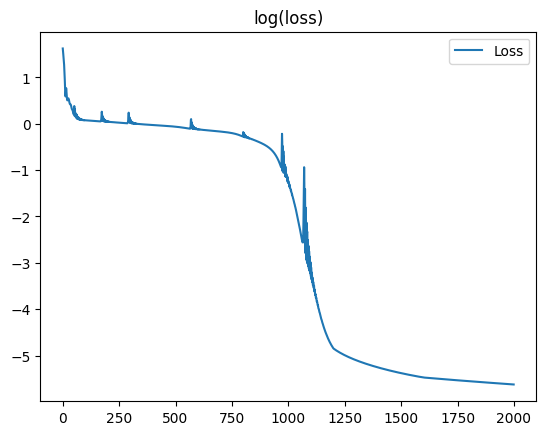

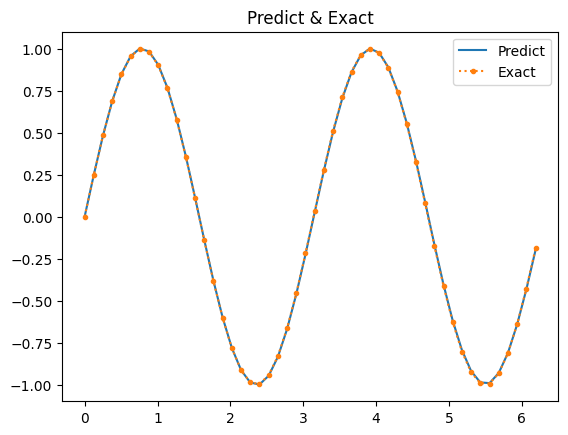

In [4]:
a = 1
b = 0.5
c = 3
# a*u_tt+b*u_t+c*u=fL

T = 2 * np.pi
Num = 200
t = np.linspace(0, T, Num).reshape(-1, 1)

X_pde = torch.tensor(t, dtype=torch.float32, requires_grad=True).to(device)
X_data = torch.tensor(np.array([0]).reshape(-1,1), dtype=torch.float32, requires_grad=True).to(device)

model = MLP(1,100,1).to(device)
PINNs_model = PINN_Vibratec(model, a, b, c)
loss = PINNs_model.train(x_pde = X_pde, x_data = X_data, epochs = 2000, learning_rate = 1e-3)
PINNs_model.plot_loss()
PINNs_model.plot_result(X_pde[::4])